In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Most recent date in the data set is {recent_date[0]}.")

Most recent date in the data set is 2017-08-23.


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

sel = [Measurement.date, Measurement.prcp]
queryresult_recent = session.query(*sel).filter(Measurement.date==recent_date[0]).all()
#queryresult_recent

# inspector = inspect(engine)

# col_list = inspector.get_columns('Measurement')
# for col in col_list:
#     print(col['name'])
#     print(col['type'])


# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date[0], "%Y-%m-%d")
year_ago = dt.date(recent_date.year -1, recent_date.month, recent_date.day)
print(f"The date one year ago from recent date is {year_ago}.")


# Perform a query to retrieve the data and precipitation scores

query_one_year = session.query(*sel).filter(Measurement.date >= year_ago).all()
#print(f"Date and precipitation a year before the most recent date, {query_one_year}")

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(query_one_year, columns=["Date", "Precipitation"])
prcp_df = prcp_df.dropna().set_index("Date")
#prcp_df

# Sort the dataframe by date

prcp_df = prcp_df.sort_values("Date")
prcp_df

The date one year ago from recent date is 2016-08-23.


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


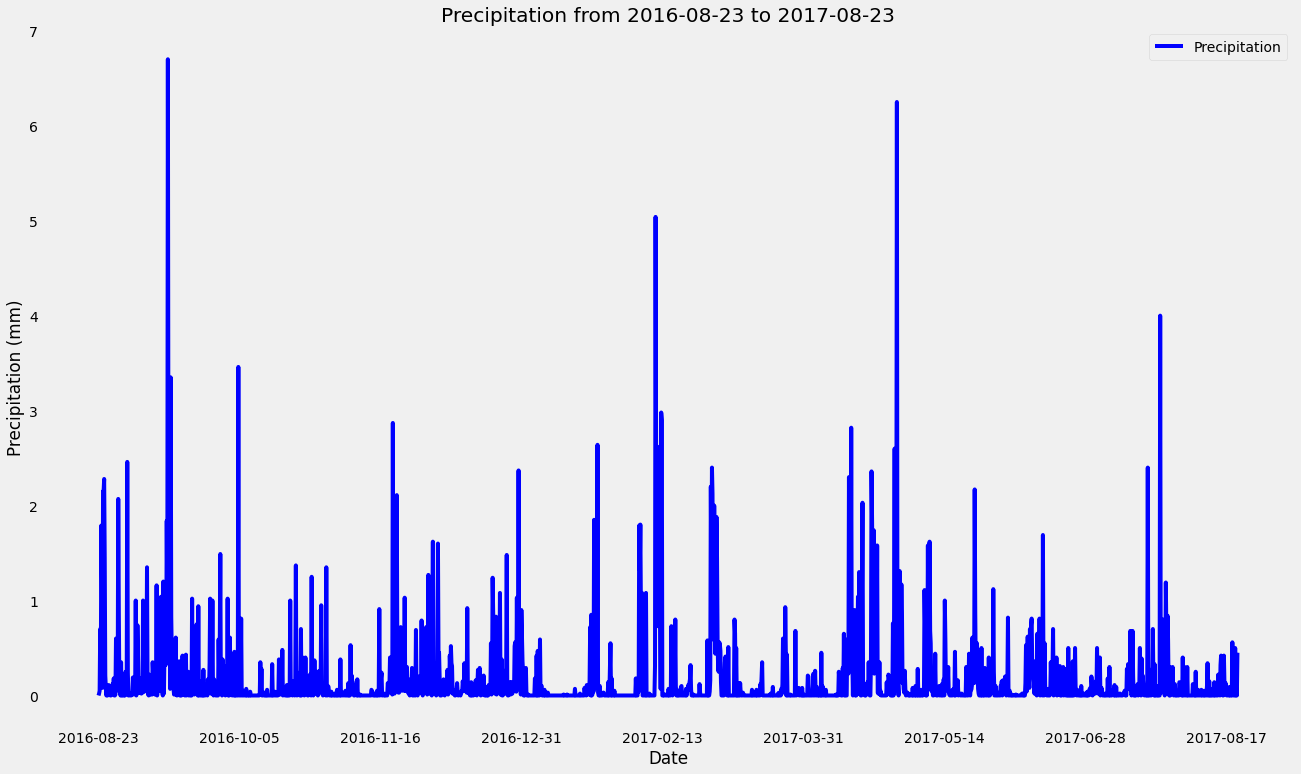

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(color="blue", figsize=(20, 12))
plt.title("Precipitation from 2016-08-23 to 2017-08-23")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Date")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_temp = (
    session.query(
        func.min(Measurement.tobs) ,
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == active_stations[0][0])
    .all()
)
print(station_temp)
print(f"The most active station is {active_stations[0][0]}.")
print(f"Lowest temperature of the most active station is {station_temp[0][0]}F.")
print(f"Highest temperature of the most active station is {station_temp[0][1]}F.")
print(f"Average temperature of the most active station is {station_temp[0][2]}F.")

[(54.0, 85.0, 71.66378066378067)]
The most active station is USC00519281.
Lowest temperature of the most active station is 54.0F.
Highest temperature of the most active station is 85.0F.
Average temperature of the most active station is 71.66378066378067F.


In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_station_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == active_stations[0][0]).all()
query_station_temp

st_temp_df = pd.DataFrame(query_station_temp, columns = ['Date','Temp'])
#st_temp_df
st_temp_df = st_temp_df.set_index('Date')
st_temp_df

,Temp
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


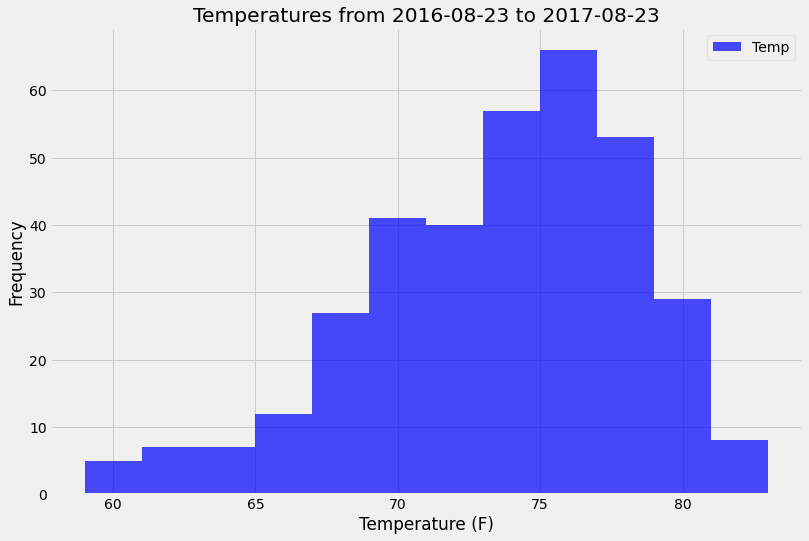

In [46]:
#histogram
st_temp_df.plot(kind="hist", color="blue", bins=12, alpha=0.7, figsize=(12, 8), grid=True)
plt.title("Temperatures from 2016-08-23 to 2017-08-23")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()

# Close session

In [47]:
# Close Session
session.close()